In [263]:
#Eigenvector substitution (reduction to 2gen)
import sympy as sp
from functions import *
import numpy as np
from sympy.matrices import matrix_multiply_elementwise
import matplotlib.pyplot as plt 
#sp.init_printing(use_latex="mathjax")
import matplotlib
from numerical import P_num_over_E_single as P_num
matplotlib.rc('text', usetex=False)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

m_21, m_31, m_41 = sp.symbols("dm_21 dm_31 dm_41", real = True, constant=True)
th_12, th_13,th_23,th_34,th_23,th_14, th_24 = sp.symbols('theta_12 theta_13 theta_23 theta_34 theta_23 theta_14 theta_24', real = True, constant=True)
E = sp.symbols('E', real = True)
d_ij=sp.symbols('delta_ij')
V_cc, V_nc,= sp.symbols("V_cc,V_nc", real = True, constant=True)
A_cc, A_nc,= sp.symbols("A_cc,A_nc", real = True, constant=True)
param_dict_num =param_dict # Regular dict with parameter values
param_dict_sym = {'theta_12': th_12, # Symbolic dict with sympy symbols
                'theta_13': th_13,
                'theta_23': th_23,
                'theta_34': th_34,
                'theta_24': th_24,
                'theta_14': th_14,
                'delta_ij': d_ij,
                'dm_21': m_21,
                'dm_31': m_31,
                'dm_41': m_41}

def V_ijab(i,j,a,b, A=0,params=param_dict_sym): # Blennow 78:807 delta_ij = 0
    if a == b:
        if a == i or a == j:
            return sp.cos(theta(i,j,A, params=params))
        else:
            return 1
    else:
        if a == i and b == j:
            return sp.sin(-theta(i,j,A, params=params)) 
        elif a == j and b == i:
            return -sp.sin(-theta(i,j,A, params=params))
        else:
            return 0


def V_matrix(i,j, A=0, n = 0, params=param_dict_sym): # Blennow 78:807
    result = sp.zeros(3+n,3 + n)
    for a in range(1, 4+n):
        elem1 = [V_ijab(i,j,a,b,A, params=params) for b in range(1, 3 + n + 1)]
        result[a-1] = elem1
    return result

def U_nu(ndim,A=0,params=param_dict_sym):
    if ndim == 4:
        return V_matrix(3,4,A,1, params=params) @ V_matrix(2,4,A,1, params=params) @ V_matrix(1,4,A,1, params=params) @ V_matrix(2,3,A,1, params=params) @ V_matrix(1,3,A,1, params=params)@ V_matrix(1,2,A,1, params=params)
    elif ndim == 3:
        return V_matrix(2,3,A,0, params=params) @ V_matrix(1,3,A,0, params=params)@ V_matrix(1,2,A,0, params=params)
    elif ndim == 2: #sin blir -sin jmf med U i constants
        return V_matrix(1,2,A,-1, params=params)
def get_H_(En,params,mtype, anti):
    '''
    En in [GeV]
    '''
    if mtype == 'full':
        U = U_nu(4, params=params)
    elif mtype == 'single':
        U = V_matrix(3,4,0,1, params=params) @ V_matrix(2,4,0,1, params=params) @ V_matrix(1,4,0,1, params=params)
    if anti:
        #A = -sp.diag(2*E*V_cc, 0 , 0, 2*E*V_nc)
        M = sp.diag(0,params['dm_21'],params['dm_31'],-params['dm_41'])
    else:
        M = sp.diag(0,params['dm_21'],params['dm_31'],params['dm_41'])
    A = sp.diag(2*E*V_cc, 0 , 0, 2*E*V_nc)
    H = 1/(2*E*1e9) * (U @ M @ U.T + A*1e18)
    H = H.subs(E,En)
    return H

def get_H_vac(En,params,mtype, anti):
    '''
    En in [GeV]
    '''
    if mtype == 'full':
        U = U_nu(4, params=params)
    elif mtype == 'single':
        U = V_matrix(3,4,0,1, params=params) @ V_matrix(2,4,0,1, params=params) @ V_matrix(1,4,0,1, params=params)
    if anti:
        #A = -sp.diag(2*E*V_cc, 0 , 0, 2*E*V_nc)
        M = sp.diag(0,params['dm_21'],params['dm_31'],-params['dm_41'])
    else:
        M = sp.diag(0,params['dm_21'],params['dm_31'],params['dm_41'])
    H = 1/(2*E*1e9) * (U @ M @ U.T)
    H = H.subs(E,En)
    return H

def diagonalize_H_(H,anti):
    #TODO: clean up
    UM_unsorted, HM_unsorted = H.diagonalize(reals_only=False,sort=True, normalize=True) 
    HM_unsorted = np.diag(np.asarray(HM_unsorted))
    UM_unsorted = np.asarray(UM_unsorted)
    if anti:
        UM_sorted = np.array([UM_unsorted[:,0], UM_unsorted[:,2], UM_unsorted[:,1], UM_unsorted[:,3]])
        HM_sorted = np.array([HM_unsorted[0], HM_unsorted[1], HM_unsorted[2], HM_unsorted[3]])
    else:
        UM_sorted = np.array([UM_unsorted[:,1], UM_unsorted[:,2], UM_unsorted[:,3], UM_unsorted[:,0]])
        HM_sorted = np.array([HM_unsorted[1], HM_unsorted[2], HM_unsorted[3], HM_unsorted[0]])
    return UM_sorted, HM_sorted

    
def get_dmM_(HM, En):
    '''
    En in [GeV]
    '''
    eigenvals = HM * np.array([1,1,1,1])
    dmM_res = 2 * En * 1e9 * eigenvals
    return dmM_res

def get_Usquared_(UM):
    UM_squared =(UM*UM)
    UMe = UM_squared[:,0]
    UMm = UM_squared[:,1]
    UMt = UM_squared[:,2]
    UMs = UM_squared[:,3]
    return UMe, UMm, UMt, UMs


def get_dmM(En, params, mtype, anti):
    '''
    En in [GeV]
    '''
    H = get_H_(En, params=params, mtype=mtype, anti=anti)
    UM,HM= diagonalize_H_(H,anti)
    dmM = get_dmM_(HM, En)
    return dmM


def get_UMsq(En, params, mtype, anti):
    '''
    En in [GeV]
    '''
    H = get_H_(En, params=params, mtype=mtype, anti=anti)
    UM,HM= diagonalize_H_(H,anti)
    UMsq = get_Usquared_(UM)
    return UMsq


def get_UM(En, params, mtype, anti):
    '''
    En in [GeV]
    '''
    H = get_H_(En, params=params, mtype=mtype, anti=anti)
    UM,HM= diagonalize_H_(H, anti)
    return UM  


def P_an_single(alpha,beta,En,L, params, anti):
    dmM = np.asarray(get_dmM(En,params,'single', anti=anti)).astype(np.float64)
    UM_single = np.asarray(get_UM(En, params,'single', anti=anti)).astype(np.float64)
    Ufrom = UM_single[alpha]
    Uto = UM_single[beta]
    params_with_dmM = params.copy()
    params_with_dmM.update({'dm_21': dmM[1], 'dm_31': dmM[2], 'dm_41': dmM[3]})
    P_list=[]
    for k in range(0, 4):
        for j in range(0, k): #1605.08607 eq3, giunti 7.38 and 7.51
            m = dm(k+1,j+1, params=params_with_dmM)
            #if not np.isclose(m,0.):
            #    print(f'dmM{k+1}{j+1}:', m)
            U_product = Ufrom[k] * Uto[k] * Ufrom[j] * Uto[j]
            real_part = U_product*np.sin(GeV2tokm1*m*L/(4*En)) ** 2 
            P_list.append(real_part)
    if  (Ufrom== Uto).all():
        return 1 -4*np.sum(P_list)
    else:
        return -4*np.sum(P_list) 
    #Define numeric parameters
full_params = {'dm_21': param_dict_num['dm_21'],
                    'dm_31': param_dict_num['dm_31'],
                    'dm_41': param_dict_num['dm_41'],
                    'delta_ij': 0,
                    'theta_12': param_dict_num['theta_12'],
                    'theta_13': param_dict_num['theta_13'],
                    'theta_23': param_dict_num['theta_23'],
                    'theta_14': np.arcsin(np.sqrt(0)),
                    'theta_24': np.arcsin(np.sqrt(0.04))/2,
                    'theta_34': np.arcsin(np.sqrt(0))
                       }
single_params =  {'dm_21': 0,
                       'dm_31': 0,
                       'dm_41': param_dict_num['dm_41'],
                       'delta_ij': 0,
                       'theta_12': param_dict_num['theta_12'],
                       'theta_13': param_dict_num['theta_13'],
                       'theta_23': param_dict_num['theta_23'],
                       'theta_14': np.arcsin(np.sqrt(0)),
                       'theta_24': np.arcsin(np.sqrt(0.04))/2,
                       'theta_34': np.arcsin(np.sqrt(0))
                       }
V_cc = np.sqrt(2) * GF * 0.5 * N_A * 8.44 * (1/GeVtocm1)**3 #GeV
V_nc = V_cc / 2 #GeV
def to_num(symb):
    try:
        return symb.subs(m_41,single_params['dm_41']).subs(th_24,single_params['theta_24'].subs(E,En))
    except AttributeError:
        return symb.subs(m_41,single_params['dm_41']).subs(th_24,single_params['theta_24'])

In [405]:
E_range = np.logspace(-9,4,50)
E_range_short = np.logspace(3,4,100)
anti = False
dmM_single = np.transpose([get_dmM(En,single_params,'single', anti=anti) for En in E_range_short])[0]
dmM_full = np.transpose([get_dmM(En,full_params,'full', anti=anti) for En in E_range_short])[0]
UMsq_single = np.transpose([get_UMsq(En, single_params,mtype='single', anti=anti) for En in E_range_short])
UMsq_full = np.transpose([get_UMsq(En, full_params, mtype='full', anti=anti) for En in E_range_short])

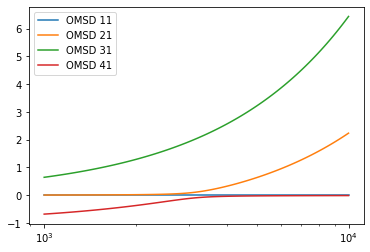

In [406]:
dmM_single = np.transpose([get_dmM(En,single_params,'single', anti=False ) for En in E_range_short])
plt.plot(E_range_short, dmM_single[0], label='OMSD 11')
plt.plot(E_range_short, dmM_single[1], label='OMSD 21')
plt.plot(E_range_short, dmM_single[2], label='OMSD 31')
plt.plot(E_range_short, dmM_single[3], label='OMSD 41')
#plt.plot(E_range, dmM_full[0], label='full dm41')
#plt.plot(E_range, dmM_single[1], label='OMSD dm21')
#plt.plot(E_range, dmM_full[1], label='full dm21')
#plt.plot(E_range, dmM_single[2], label='OMSD dm31')
#plt.plot(E_range, dmM_full[2], label='full dm31')
plt.xscale('log')
plt.legend()

Text(0.5, 0.98, 'Oscillation probabilities')

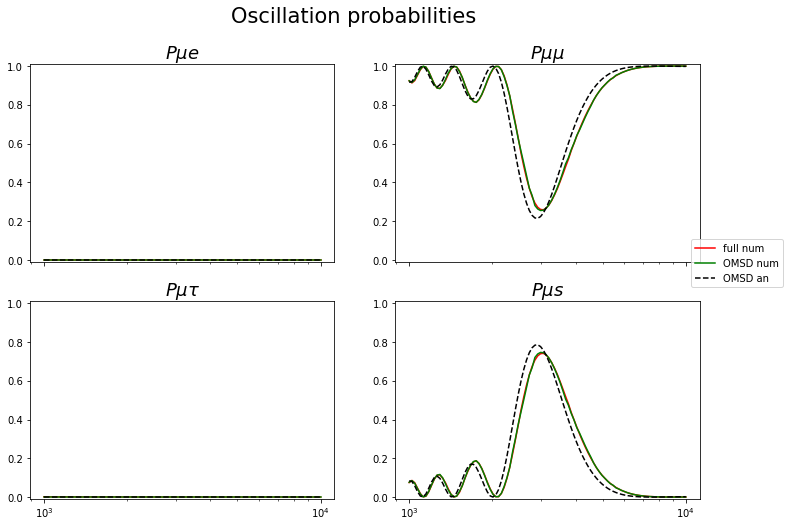

In [407]:
flavors=['e','\\mu','\\tau','s']
#E_range_short = np.logspace(3,4,100)

fig, ax = plt.subplots(2,2, sharex=True)
fig.set_size_inches((12,8))
ax = ax.flatten()

P_num_single = P_num('m',E_range_short,ndim=4, params=single_params, vacuum=False, anti=anti, material=8.44)
P_num_full = P_num('m',E_range_short,ndim=4, params=full_params, vacuum=False, anti=anti, material=8.44)

for i in range(4):
    ax[i].set_title(rf'$P\mu {flavors[i]}$',fontsize=18)
    ax[i].set_ylim((-0.01,1.01))
    ax[i].set_xscale('log')
    P_an_list_single=[]
    P_an_list_full=[]
    for En in E_range_short:
        P_an_list_single.append(P_an_single(alpha=1,beta=i,En=En,L=2*r_earth, params=single_params, anti=anti))
    ax[i].plot(E_range_short, P_num_full[i], label='full num', c='r')
    ax[i].plot(E_range_short, P_num_single[i], label='OMSD num', c='g')
    ax[i].plot(E_range_short, P_an_list_single, label='OMSD an',linestyle='--', c='black')
handles, labels = ax[3].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.suptitle('Oscillation probabilities', fontsize=21)

Text(-0.02, 0.4, ' dm_21: 7.42e-05 \n dm_31: 0.002514 \n dm_41: -1 \n sin_14: 0.0 \n sin_24: 0.04 \n sin_34: 0.0 \n')

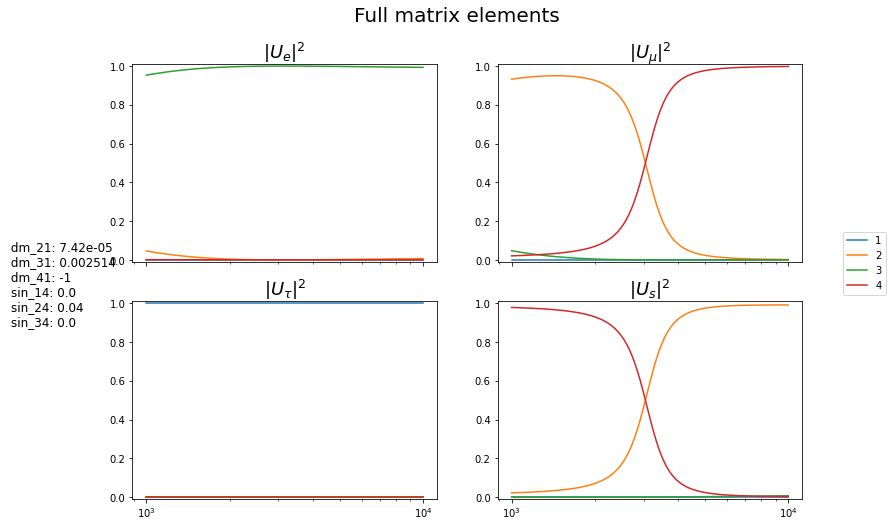

In [5]:
flavors=['e','\mu','\\tau','s']
fig, ax = plt.subplots(2,2, sharex=True)
fig.set_size_inches((12,8))
ax = ax.flatten()
for i in range(4):
    ax[i].set_title(rf'$|U_{flavors[i]}|^2$',fontsize=18)
    ax[i].set_ylim((-0.01,1.01))
    ax[i].set_xscale('log')
    for k in range(4):
        ax[i].plot(E_range_short, UMsq_full[i][k], label=k+1)
handles, labels = ax[3].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.suptitle('Full matrix elements', fontsize=20)
str_param=f' dm_21: {full_params["dm_21"]} \n dm_31: {full_params["dm_31"]} \n dm_41: {full_params["dm_41"]} \n sin_14: {np.round(np.sin(2*full_params["theta_14"])**2,2)} \n sin_24: {np.round(np.sin(2*full_params["theta_24"])**2,2)} \n sin_34: {np.round(np.sin(2*full_params["theta_34"])**2,2)} \n'
plt.gcf().text(-0.02, 0.4, str_param, fontsize=12)

Text(-0.02, 0.4, ' dm_21: 0 \n dm_31: 0 \n dm_41: -1 \n sin_14: 0.0 \n sin_24: 0.15 \n sin_34: 0.0 \n')

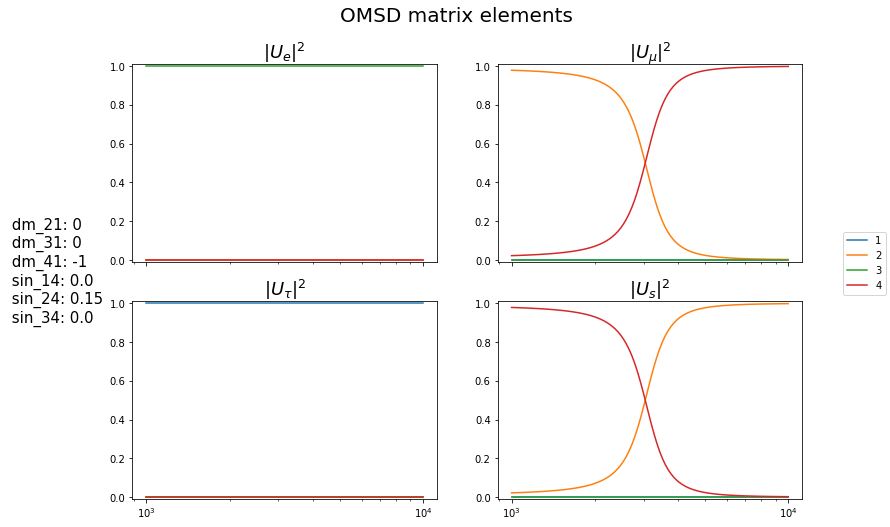

In [6]:
flavors=['e','\mu','\\tau','s']
fig, ax = plt.subplots(2,2, sharex=True)
fig.set_size_inches((12,8))
ax = ax.flatten()
for i in range(4):
    ax[i].set_title(rf'$|U_{flavors[i]}|^2$',fontsize=18)
    ax[i].set_ylim((-0.01,1.01))
    ax[i].set_xscale('log')
    for k in range(4):
        ax[i].plot(E_range_short, UMsq_single[i][k], label=k+1)
handles, labels = ax[3].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.suptitle('OMSD matrix elements', fontsize=20)

#Show parameters
str_param=f' dm_21: 0 \n dm_31: 0 \n dm_41: {param_dict_num["dm_41"]} \n sin_14: {np.round(np.sin(2*param_dict_num["theta_14"])**2,2)} \n sin_24: {np.round(np.sin(2*param_dict_num["theta_24"])**2,2)} \n sin_34: {np.round(np.sin(2*param_dict_num["theta_34"])**2,2)} \n'
plt.gcf().text(-0.02, 0.4, str_param, fontsize=15)

In [384]:
symb_params_simple = param_dict_sym.copy()
symb_params = param_dict_sym.copy()

symb_params.update({'theta_12': param_dict_num['theta_12'],
                       'theta_13': param_dict_num['theta_13'],
                       'theta_23': param_dict_num['theta_23'],
                       'theta_14': 0,
                       'theta_24': param_dict_sym['theta_24'],
                       'theta_34': param_dict_sym['theta_24'],
                       'dm_21': 0,
                       'dm_31': 0,
                       'dm_41': param_dict_num['dm_41']
                       })

symb_params_simple.update({'theta_12': 1,
                       'theta_13': 1,
                       'theta_23': 1,
                       'theta_14': 0,
                       'theta_24': param_dict_sym['theta_24'],
                       'theta_34': param_dict_sym['theta_34'],
                       'dm_21': 0,
                       'dm_31': 0,
                       'dm_41': param_dict_num['dm_41']
                       })

In [512]:
H=get_H_(3e3,symb_params_simple,mtype='single', anti=False)
H

Matrix([
[3.22090090472949e-13,                                                               0,                                                                  0,                                                                              0],
[                   0,                          -1.66666666666667e-13*sin(theta_24)**2,    -1.66666666666667e-13*sin(theta_24)*sin(theta_34)*cos(theta_24),                -1.66666666666667e-13*sin(theta_24)*cos(theta_24)*cos(theta_34)],
[                   0, -1.66666666666667e-13*sin(theta_24)*sin(theta_34)*cos(theta_24),            -1.66666666666667e-13*sin(theta_34)**2*cos(theta_24)**2,             -1.66666666666667e-13*sin(theta_34)*cos(theta_24)**2*cos(theta_34)],
[                   0, -1.66666666666667e-13*sin(theta_24)*cos(theta_24)*cos(theta_34), -1.66666666666667e-13*sin(theta_34)*cos(theta_24)**2*cos(theta_34), -1.66666666666667e-13*cos(theta_24)**2*cos(theta_34)**2 + 1.61045045236475e-13]])

In [510]:
UM_vac, HM_vac = get_H_vac(3e3,symb_params_simple,mtype='single', anti=False).diagonalize(reals_only=False,sort=True, normalize=True)

In [513]:
UM, HM = H.diagonalize(reals_only=False,sort=True, normalize=True)

In [508]:
UM

Matrix([
[                                                                             0, 1.0,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [514]:
UM.subs({th_24:np.pi/4, th_34:np.pi/4})

Matrix([
[                 0, 1.0,                 0,                  0],
[-0.577350269189626,   0, 0.787619026927415, -0.215227635513146],
[ 0.816496580927726,   0, 0.556930754931923, -0.152188920570092],
[                 0,   0, 0.263598942776464,  0.964632363839784]])

In [515]:
UM_e = UM[:,1]
UM_s = UM[:,3]
#HM_m = HM[:,2]
#HM_s = HM[:,3]

In [414]:
U_symb = V_matrix(3,4,0,1, params=symb_params_simple) @ V_matrix(2,4,0,1, params=symb_params_simple) @ V_matrix(1,4,0,1, params=symb_params_simple)

In [415]:
U_symb.subs({th_24:np.pi/4, th_34:np.pi/8})

Matrix([
[1,                  0,                 0,                 0],
[0,  0.707106781186548,                 0, 0.707106781186547],
[0, -0.270598050073098, 0.923879532511287, 0.270598050073099],
[0, -0.653281482438188, -0.38268343236509, 0.653281482438188]])

In [416]:
U_symb

Matrix([
[1,                            0,              0,                           0],
[0,                cos(theta_24),              0,               sin(theta_24)],
[0, -sin(theta_24)*sin(theta_34),  cos(theta_34), sin(theta_34)*cos(theta_24)],
[0, -sin(theta_24)*cos(theta_34), -sin(theta_34), cos(theta_24)*cos(theta_34)]])

In [516]:
replacements, reduced = sp.cse(UM_s[1], optimizations='basic')

In [517]:
reduced[0]

1.0*x12/sqrt(x1*Abs(x2*(163855855951571.0*x6 - 2810810715096.0)*sin(theta_34)/(x5*x7 + 2.63723724202299e+28*x5 - 2.63881737339821e+28*x6 - 2.63881737339821e+28))**2 + Abs(x12)**2 + 3.59999999999999e-29)

In [518]:
den = replacements[5][0]*replacements[7][0]+2.63723724202299e28*replacements[6][0]-2.63881737339821e28*replacements[7][0]-2.63881737339821e28
num=replacements[2][0]*(163855855951571.0*replacements[6][0]-2810810715096.0)*sp.sin(th_34)


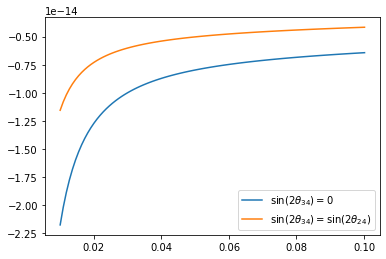

In [526]:
#x12 is well behaved
x12 = sp.simplify(replacements[12][0].subs(replacements).subs(replacements).subs(replacements).subs(replacements).subs(replacements).subs(replacements).subs(replacements))
x12_func = sp.lambdify([th_24,th_34],x12,'numpy')
theta_range1 = np.linspace(0.01,np.arcsin(np.sqrt(0.04)/2),100)
plt.plot(theta_range1,x12_func(theta_range1,0), label='$\sin{(2\\theta_{34})} = 0$')
plt.plot(theta_range1,x12_func(theta_range1,theta_range1), label='$\sin{(2\\theta_{34})} = \sin{(2\\theta_{24})}$')
plt.legend()

Text(0.5, 0, '$\\sin{(2\\theta_{24})}$')

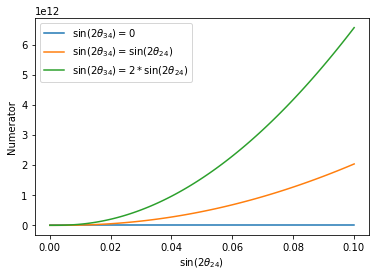

In [531]:
# the sqrt is not well behaved. numerator is strictly zero for th34=0 since it depends on sin(th34). When th34 != 0, the numerator is prop to 1e12.
den1 = sp.simplify(den.subs(replacements).subs(replacements).subs(replacements).subs(replacements).subs(replacements))
num1 = sp.simplify(num.subs(replacements).subs(replacements).subs(replacements).subs(replacements).subs(replacements))
den1_func = sp.lambdify([th_24,th_34],den1,'numpy')
num1_func = sp.lambdify([th_24,th_34],num1,'numpy')
fig, ax = plt.subplots(1,1)

fig, ax = plt.subplots(1,3)
ax[0].plot(theta_range,den1_func(theta_range,0), label='$\sin{(2\\theta_{34})} = 0$')
ax[0].plot(theta_range,den1_func(theta_range,theta_range), label='$\sin{(2\\theta_{34})} = \sin{(2\\theta_{24})}$')
ax[0].plot(theta_range,den1_func(theta_range,2*theta_range), label='$\sin{(2\\theta_{34})} = 2*\sin{(2\\theta_{24})}$')

ax[1].plot(theta_range,num1_func(theta_range,0), label='$\sin{(2\\theta_{34})} = 0$')
ax[1].plot(theta_range,num1_func(theta_range,theta_range), label='$\sin{(2\\theta_{34})} = \sin{(2\\theta_{24})}$')
ax[1].plot(theta_range,num1_func(theta_range,2*theta_range), label='$\sin{(2\\theta_{34})} = 2*\sin{(2\\theta_{24})}$')

ax[2].plot(theta_range,num1_func(theta_range,0)/den1_func(theta_range,0), label='$\sin{(2\\theta_{34})} = 0$')
ax[2].plot(theta_range,num1_func(theta_range,theta_range)/den1_func(theta_range,theta_range), label='$\sin{(2\\theta_{34})} = \sin{(2\\theta_{24})}$')
ax[2].plot(theta_range,num1_func(theta_range,2*theta_range)/den1_func(theta_range,2*theta_range), label='$\sin{(2\\theta_{34})} = 2*\sin{(2\\theta_{24})}$')

#plt.plot(np.sin(2*theta_range),np.abs(UMs2_func(theta_range,np.arcsin(np.sqrt(0.02))/2)), label='$\sin{(2\\theta_{34})} = 0.02$')
#plt.plot(np.sin(2*theta_range),np.abs(UMs2_func(theta_range,np.arcsin(np.sqrt(0.04))/2)), label='$\sin{(2\\theta_{34})} = 0.04$')
plt.legend()
plt.ylabel('Numerator')
plt.xlabel('$\sin{(2\\theta_{24})}$')

In [533]:
num1.subs(th_24,theta_range)

(163855855951571.0*(-0.999705734554918*cos(theta_24)**2*cos(theta_34)**2 + 1)**0.5 - 2810810715096.0)*sin(theta_34)*cos(theta_34)

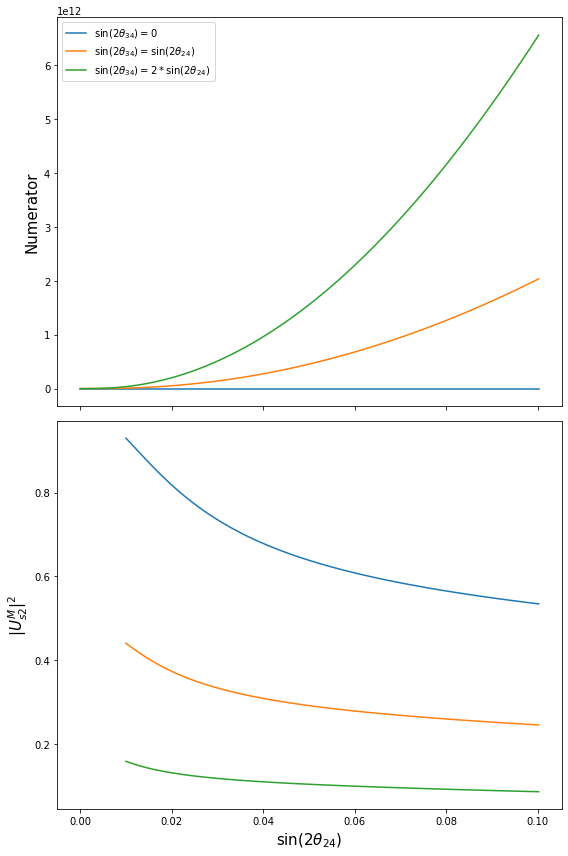

In [548]:
UMs2_func = sp.lambdify([th_24,th_34],UM_s[1],'numpy')
fig, ax = plt.subplots(2,1, figsize=(8,12), sharex=True, tight_layout=True)
ax[0].plot(theta_range,num1_func(theta_range,0), label='$\sin{(2\\theta_{34})} = 0$')
ax[0].plot(theta_range,num1_func(theta_range,theta_range), label='$\sin{(2\\theta_{34})} = \sin{(2\\theta_{24})}$')
ax[0].plot(theta_range,num1_func(theta_range,2*theta_range), label='$\sin{(2\\theta_{34})} = 2*\sin{(2\\theta_{24})}$')
ax[1].plot(theta_range1, UMs2_func(theta_range1,0)**2)
ax[1].plot(theta_range1, UMs2_func(theta_range1,theta_range1)**2)
ax[1].plot(theta_range1, UMs2_func(theta_range1,2*theta_range1)**2)

ax[0].set_ylabel('Numerator', fontsize=15)
ax[1].set_ylabel('$|U^M_{s2}|^2$', fontsize=15)
ax[1].set_xlabel('$\sin{(2\\theta_{24})}$', fontsize=15)
ax[0].legend()

In [419]:
UMs2 = sp.simplify(UM_s[1].subs(sp.sin(th_24),th_24).subs(sp.cos(th_24),1).subs(sp.sin(th_34),th_34).subs(sp.cos(th_34),1))
UMs3 = sp.simplify(UM_s[2].subs(sp.sin(th_24),th_24).subs(sp.cos(th_24),1).subs(sp.sin(th_34),th_34).subs(sp.cos(th_34),1))
UMs4 = sp.simplify(UM_s[3].subs(sp.sin(th_24),th_24).subs(sp.cos(th_24),1).subs(sp.sin(th_34),th_34).subs(sp.cos(th_34),1))

UMs2_func = sp.lambdify([th_24,th_34],UMs2,'numpy')
UMs3_func = sp.lambdify([th_24,th_34],UMs3,'numpy')
UMs4_func = sp.lambdify([th_24,th_34],UMs4,'numpy')

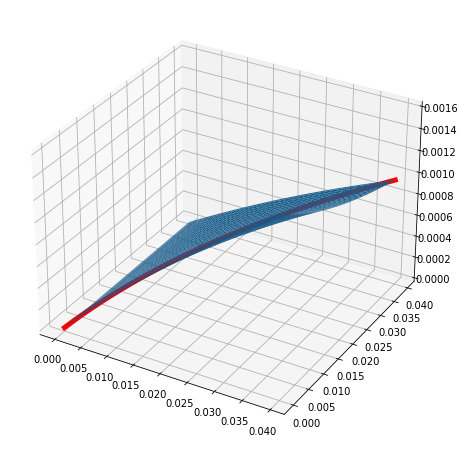

In [420]:
%matplotlib inline
theta_range = np.linspace(0,np.arcsin(np.sqrt(0.04)/2),100)
X, Y = np.meshgrid(theta_range, theta_range)
Z = UMs2_func(X,Y)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(np.sin(2*theta_range)**2,np.sin(2*theta_range)**2,UMs2_func(theta_range,theta_range)**2, c='r', lw=5)
ax.plot_surface(np.sin(2*X)**2,np.sin(2*Y)**2,Z**2)

Text(0.5, 0, '$\\sin{(2\\theta_{24})}$')

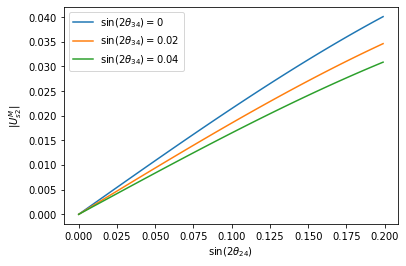

In [424]:
plt.plot(np.sin(2*theta_range),np.abs(UMs2_func(theta_range,0)), label='$\sin{(2\\theta_{34})} = 0$')
plt.plot(np.sin(2*theta_range),np.abs(UMs2_func(theta_range,np.arcsin(np.sqrt(0.02))/2)), label='$\sin{(2\\theta_{34})} = 0.02$')
plt.plot(np.sin(2*theta_range),np.abs(UMs2_func(theta_range,np.arcsin(np.sqrt(0.04))/2)), label='$\sin{(2\\theta_{34})} = 0.04$')
plt.legend()
plt.ylabel('$|U^M_{s2}|$')
plt.xlabel('$\sin{(2\\theta_{24})}$')

In [11]:
# A lot of this is redundant, but its to prove that we can do this approx

L = 2*r_earth
Pmm_num_full= P_num('m',[En],ndim=4,params=full_params,material=8.44)[1]
Pmm_num_single = P_num('m',[En],ndim=4,params=single_params,material=8.44)[1]
Pmm_an_single = P_an_single(alpha=1,beta=1,En=En,L=2*r_earth, params=single_params, anti=False)
Pmm_an_full = P_an_single(alpha=1,beta=1,En=En,L=2*r_earth, params=full_params, anti=False)

_,UMmsq,_,_ =get_UMsq(En,single_params,'single', anti=anti)
Um1,Um2,Um3,Um4 = UMmsq
_,dm21,dm31,dm41 = get_dmM(En,single_params,'single', anti=anti)
s21 = sp.sin(GeV2tokm1*dm21*L/(4*En)) ** 2
s31 = sp.sin(GeV2tokm1*dm31*L/(4*En)) ** 2
s32 = sp.sin(GeV2tokm1*(dm31-dm21)*L/(4*En)) ** 2
s41 = sp.sin(GeV2tokm1*dm41*L/(4*En)) ** 2
s42 = sp.sin(GeV2tokm1*(dm41-dm21)*L/(4*En)) ** 2
s43 = sp.sin(GeV2tokm1*(dm41-dm31)*L/(4*En)) ** 2
Uprod_full = Um1*(Um2*s21 + Um3*s31 + Um4*s41) + Um2*(Um3*s32 + Um4*s42) + Um3*(Um4*s43) #Full expression.
Pmm_full = 1-4*Uprod_full
Uprod =  Um2*Um4*s42 #Taking into account that Um1=Um3 = 0 at TeV
Pmm = 1-4*Uprod
print(Pmm,Pmm_num_full) # The fact that Pmm and Pmm_num_full are so close validates the form of Pmm

0.214491652614329 [0.27142414]


In [12]:
anti = True
L = 2*r_earth
_,UMmsq_symb,_,_ = get_UMsq(E, symb_params,'single', anti = anti)#WARNING: get_UMsq and get_dmM returns elements in different order depending on parameter values! Double check returned arrays!
_,dmM21_symb,dmM41_symb,_ = get_dmM(E,symb_params,'single', anti=anti)
dm42_symb = dmM41_symb - dmM21_symb
s42_symb = sp.sin(GeV2tokm1*dm42_symb*L/(4*E)) ** 2
_,Um4_symb,Um2_symb,_ = UMmsq_symb 
Pmm_symb = 1-4*Um2_symb*Um4_symb*s42_symb

NotImplementedError: Can't evaluate eigenvector for eigenvalue (322090090472949*E + sqrt(103742026380872472174500756601*E**2*sin(2) - 80522522618237250000000000000000*E*sin(6) + 241567567854711750000000000000000*E*sin(2) - 322090090472949000000000000000000*E*sin(4) + 1000000000000000000000000000000000000*sin(2))/sqrt(sin(2)) - 1000000000000000000)/(4000000000000000000000000000*E)

In [16]:
def get_H_A(En,params,mtype, anti):
    '''
    En in [GeV]
    '''
    if mtype == 'full':
        U = U_nu(4, params=params)
    elif mtype == 'single':
        U = V_matrix(3,4,0,1, params=params) @ V_matrix(2,4,0,1, params=params) @ V_matrix(1,4,0,1, params=params)
    if anti:
        #A = -sp.diag(2*E*V_cc, 0 , 0, 2*E*V_nc)
        M = sp.diag(0,params['dm_21'],params['dm_31'],-params['dm_41'])
    else:
        M = sp.diag(0,params['dm_21'],params['dm_31'],params['dm_41'])
    A = sp.diag(A_cc, 0 , 0, A_nc)
    H = 1/(2*E*1e9) * (U @ M @ U.T + A*1e18)
    H = H.subs(E,En)
    return H
H_block = get_H_A(E,symb_params,'single',True)[1:4,1:4]

In [14]:
fun = sp.lambdify((E,m_41,th_24),Um2_symb, 'numpy')
plt.plot(E_range_short,fun(E_range_short,single_params['dm_41'],single_params['theta_24']))
plt.plot(E_range_short, UMsq_single[1][1]) 
plt.xscale('log')

NameError: name 'Um2_symb' is not defined

In [89]:
sp.simplify(dm42_simplified)

(1.03742026380872e-7*E**2 - 0.0012883603618918*E*dm_41*sin(theta_24)**2 + 0.000644180180945898*E*dm_41 + dm_41**2)**0.5

In [9]:
c1, c2, c3, c4 = 322090090472949., 1e18, 1.03742026380872e-7, 0.000644180180945898
a1 = (c3*E**2 + c4*E*m_41*sp.cos(2*th_24)+m_41**2)**(1/2)

F = c1*E + c2*m_41*sp.cos(2*th_24) - c2*a1
F2 = c1*E + c2*m_41*sp.cos(2*th_24) + c2*a1
Um2_simplified = sp.tan(2*th_24)**2/(sp.tan(2*th_24)**2+1e-36*F**2/(m_41**2*sp.cos(2*th_24)**2))
Um4_simplified = sp.tan(2*th_24)**2/(sp.tan(2*th_24)**2+1e-36*F2**2/(m_41**2*sp.cos(2*th_24)**2))

print(to_num(Um2_simplified).subs(E,3e3),to_num(Um2_symb).subs(E,3e3)) #My algebra is correct
print(to_num(Um4_simplified.subs(E,3e3)),to_num(Um4_symb).subs(E,3e3)) #My algebra is correct

NameError: name 'Um2_symb' is not defined

In [16]:
F**2

1.0e+36*(0.000322090090472949*E + dm_41*cos(2*theta_24) - (1.03742026380872e-7*E**2 + 0.000644180180945898*E*dm_41*cos(2*theta_24) + dm_41**2)**0.5)**2

In [22]:
c5, c6 = 1.03742026380872e-7, 0.0012883603618918
dm42_simplified = (c5*E**2 - c6*E*m_41*sp.sin(th_24)**2 + c4*E*m_41 + m_41**2)**(1/2)
print(to_num(dm42_simplified).subs(E,3e3),to_num(dm42_symb).subs(E,3e3))#My algebra is correct
ph_42_simplified = dm42_simplified*GeV2tokm1*L/(4*E)

0.200456834631353 0.200456834631364


In [74]:
Pmm_simplified = 1-4*Um2_simplified*Um4_simplified*sp.sin(ph_42_simplified)**2
Pmm_symb_func = sp.lambdify((E,m_41,th_24),Pmm_simplified, 'numpy')

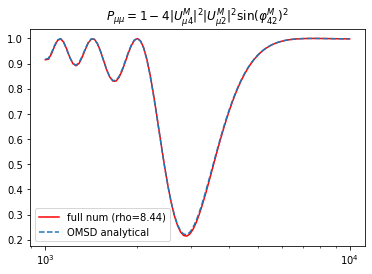

In [97]:
plt.plot(E_range_short, P_num_full[1], label='full num (rho=8.44)', c='r')
plt.plot(E_range_short, Pmm_symb_func(E_range_short,-1,0.1), label='OMSD analytical',linestyle='--')
plt.xscale('log')
plt.title(r'$P_{\mu\mu} = 1-4 |U^M_{\mu 4}|^2 |U^M_{\mu 2}|^2 \sin{(\varphi_{42}^M)}^2 $')
plt.legend()

In [25]:
Pmm_simplified

1 - 4*sin(16143.2563344481*(1.03742026380872e-7*E**2 - 0.0012883603618918*E*dm_41*sin(theta_24)**2 + 0.000644180180945898*E*dm_41 + dm_41**2)**0.5/E)**2*tan(2*theta_24)**4/((tan(2*theta_24)**2 + 1.0*(0.000322090090472949*E + dm_41*cos(2*theta_24) - (1.03742026380872e-7*E**2 + 0.000644180180945898*E*dm_41*cos(2*theta_24) + dm_41**2)**0.5)**2/(dm_41**2*cos(2*theta_24)**2))*(tan(2*theta_24)**2 + 1.0*(0.000322090090472949*E + dm_41*cos(2*theta_24) + (1.03742026380872e-7*E**2 + 0.000644180180945898*E*dm_41*cos(2*theta_24) + dm_41**2)**0.5)**2/(dm_41**2*cos(2*theta_24)**2)))

In [18]:
#Taylor series of a1 around E0
E0 = 3e3
A0 = sp.sqrt(E0**2*c3 + E0*c4*m_41*sp.cos(2*th_24) + m_41**2)
B0 = (2*E0*c3 + c4*m_41*sp.cos(2*th_24))/(2*A0)
a1_taylor = A0 + B0*(E-E0)
to_num(a1_taylor).subs(E,2.5e3),to_num(a1).subs(E,2.5e3) #taylor expansion of a1 in E is only valid in a pretty narrow range around E0

(0.211323189005434, 0.265471126771371)

In [31]:
#Insert a1_taylor in F and simplify
F_sq = c1**2*E**2 + c2**2*(m_41**2*sp.cos(2*th_24)**2 - 2*m_41*sp.cos(2*th_24)*a1_taylor + a1_taylor**2) + 2*c1*c2*E*m_41*sp.cos(2*th_24) - 2*c1*c2*a1_taylor*E
to_num(F_sq).subs(E,3e3),to_num(F**2).subs(E,3e3)

(4.57884933270731e+34, 4.57884933270729e+34)

In [59]:
F_sq_func = sp.lambdify(E, sp.simplify(to_num(F_sq)), 'numpy')
Um2_E = sp.tan(2*th_24)**2/(sp.tan(2*th_24)**2 + 1e-36*F_sq/(m_41**2*sp.cos(2*th_24)**2))
Um2_func_E= sp.lambdify((E,m_41,th_24), Um2_E,'numpy')

In [104]:
Um2_E

tan(2*theta_24)**2/(tan(2*theta_24)**2 + (1.03742026380872e-7*E**2 + 0.000644180180945898*E*dm_41*cos(2*theta_24) - 1.0e-36*E*(2.31693076602413e+32*(E - 3000.0)*(0.000644180180945898*dm_41*cos(2*theta_24) + 0.000622452158285232)/sqrt(0.517453568416022*dm_41**2 + dm_41*cos(2*theta_24) + 0.483135135709421) + 8.95512528057924e+32*sqrt(0.517453568416022*dm_41**2 + dm_41*cos(2*theta_24) + 0.483135135709421)) + 1.0*dm_41**2*cos(2*theta_24)**2 - 2.0*dm_41*(0.359671227795615*(E - 3000.0)*(0.000644180180945898*dm_41*cos(2*theta_24) + 0.000622452158285232)/sqrt(0.517453568416022*dm_41**2 + dm_41*cos(2*theta_24) + 0.483135135709421) + 1.39015845961448*sqrt(0.517453568416022*dm_41**2 + dm_41*cos(2*theta_24) + 0.483135135709421))*cos(2*theta_24) + 1.93254054283769*(0.258726784208011*(E - 3000.0)*(0.000644180180945898*dm_41*cos(2*theta_24) + 0.000622452158285232)/sqrt(0.517453568416022*dm_41**2 + dm_41*cos(2*theta_24) + 0.483135135709421) + sqrt(0.517453568416022*dm_41**2 + dm_41*cos(2*theta_24) + 0

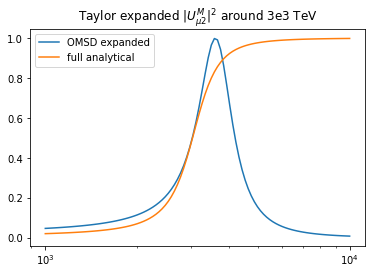

In [101]:
plt.plot(E_range_short,Um2_func_E(E_range_short,single_params['dm_41'],single_params['theta_24']), label='OMSD expanded')
plt.plot(E_range_short, UMsq_full[1][3], label='full analytical') 
plt.title(r'Taylor expanded $|U^M_{\mu 2}|^2$ around 3e3 TeV')
plt.xscale('log')
plt.legend()

In [26]:
all_symb_params = param_dict_sym.copy()
U_nu(4,params=all_symb_params)
#get forms for Us

Matrix([
[                                                                                                                                                                                                                     cos(theta_12)*cos(theta_13)*cos(theta_14),                                                                                                                                                                                                                      sin(theta_12)*cos(theta_13)*cos(theta_14),                                                                                                                        sin(theta_13)*cos(theta_14),                             sin(theta_14)],
[                                                                                                            (-sin(theta_13)*sin(theta_23)*cos(theta_24) - sin(theta_14)*sin(theta_24)*cos(theta_13))*cos(theta_12) - sin(theta_12)*cos(theta_23)*cos(theta_24),                              